scipy.ndimage是一个处理多维图像的函数库，其中还包括以下几个模块

1、filters: 图像滤波器

2、fourier：傅里叶变换

3、interpolation：图像的差值、旋转以及仿射变换等

4、measurements：图像相关信息的测量

5、morphology：形态学图像处理

除此之外还有更强大的图像处理库

scipy.ndimage()只提供了以下基础的图像处理功能，以下是更为强大的图像处理库：
* OpenCV: 它是使用C/C++开发的计算机视觉库，OpenCV也有python的调用接口；
* simpleCV： 对多个视觉库进行包装，提供了一套更加方便、统一的python调用接口；
* scikit-image： 使用python开发的图像处理库，高度部分多采用Cython编写；
* Mahotas： 使用python和C++开发的图像处理库。

# 形态学图像处理

使用morphology模块实现二值图像的处理。二值图像中的色素只有黑和白两个值。在numpy中可以使用二维布尔数组表示：False表示黑色，True表示白色，也可以用无符号的单字节整型（uint8）表示：0为黑色，非0为白色。

下面两个函数用来显示形态学图像处理的结果。

In [2]:
import numpy as np
import matplotlib.pyplot as plt

'''img为图像的像素矩阵，
value为拓展图像后非0像素统一设定值，
out为拓展后图像矩阵大小，默认为空，
size为拓展比例'''
def expand_img(img,value,out=None,size=10):
    if out is None:
        '''获取原图像矩阵大小'''
        w,h = img.shape
        '''初始化out，其大小为原图像的size倍'''
        out = np.zeros((w*size,h*size),dtype=np.uint8)
        
        '''将原图像放大size倍，np.repeat()三个参数分别表示重复元，重复次数，矩阵轴'''
        tmp = np.repeat(np.repeat(img,size,0),size,1)
        '''将tmp中所有非0值替换为value，并将其存入out'''
        out[:,:] = np.where(tmp,value,out)
#         out[::size,:] = 0
#         out[:,::size] = 0
        return out
    
def show_img(*imgs):
    '''用enumerate()产生迭代对象，第二个参数为起始序号，默认从0开始'''
    for idx,img in enumerate(imgs,1):
        '''创建子图，三个参数分别表示子图行数、列数、当前激活的子图号'''
        ax = plt.subplot(1,len(imgs),idx)
        '''imshow()可以将灰度图像按照灰度值的高低映射成彩色图像，源数据可以是数组或PIL图像，cmap表示彩色对照表colormap'''
        plt.imshow(img,cmap="gray")
        '''关闭坐标轴'''
        ax.set_axis_off()
    '''subplots_adjust()用于调整子图位置，subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=None, hspace=None)
    left  = 0.125  # 子图(subplot)距画板(figure)左边的距离
    right = 0.9    # 右边
    bottom = 0.1   # 底部
    top = 0.9      # 顶部
    wspace = 0.2   # 子图水平间距
    hspace = 0.2   # 子图垂直间距'''
    plt.subplots_adjust(0.02,0,0.98,1,0.02,0)

<font color="red" >数学形态学进行图像处理的基本思想是:用具有一定形态的结构元素探测目标图像，通过检验结构元素在图像目标中的可放性和填充方法的有效性，来获取有关图像形态结构的相关信息,进而达到对图像分析和识别的目的。</font>

### 形态学图像处理的基本步骤如下：
* 提出所要描述物体的几何结构模式，即提取几何结构特征；
* 根据结构特征选择合适的结构元素（简单而要有较强的表现力）；
* 使用选定的结构元对图像进行击中与否（HMT,Hit-Miss-Transform）变换，便得到比原始图像更显著突出物体特征信息的图像；
* 经过形态学变换后的图像突出我们所需的信息，从而可以方便的提取信息。

### 结构元选择的基本原则
1. 结构元必须在几何上比原图像简单，且有界;
2. 当选择性质相同或相似的结构元时，以选择极限情况为宜;
3. 结构元的凸性很重要，对非凸子集，由于连接两点的线段大部分位于集合的外面，故用非凸子集作为结构元将得不到什么信息。

### 1.膨胀和腐蚀

二值图像最基本的形态学运算就是膨胀和腐蚀。膨胀运算就是将原始图像中每个白色像素（物体）进行处理，将周围的黑色像素（背景）变为白色的过程。腐蚀运算真好相反。

四连通包括上下左右4个像素，而八连通还包括四角的连接元素。他们可以按下面的正方形矩阵进行定义，其正中心的元素表示当前要进行计算的像素，而其周围的1和0表示对应位置的像素是否算作“周围”像素。这种描述计算元素和周围元素关系的矩阵称作**结构元素**（structure element）。

   四连通
    
   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0          
   
   1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1          
   
   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0
   
   八连通
    
   1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1          
   
   1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1          
   
   1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1 

假设数组a是一个表示二值图像的数组，可用下面语句进行膨胀计算：

binary_dilation(a,structure=None)

binary_dilation()默认使用四连通进行膨胀计算，，通过更改struction参数可以指定其他的结构元素。下面是使用八连通膨胀运算的语句：

binary_dilation(a,[[1,1,1],[1,1,1],[1,1,1]])

(189, 189)
(1890, 1890)
(189, 189)
(189, 189)


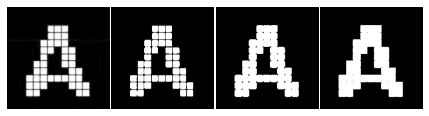

In [3]:
from scipy.ndimage import morphology

def dilation_demo(a,structure=None):
    b = morphology.binary_dilation(a,structure)
    img = expand_img(a, 255)
    return expand_img(np.logical_xor(a,b), 150, out=img)

'''读取图片信息，并将0轴通道值传递给img_gray'''
img_gray = plt.imread("图像处理1.png")[:,:,0]
'''灰度图转化'''
a = np.where(img_gray >= 0.5, 1, 0)

img1 = expand_img(a,1)

img2 =morphology.binary_dilation(a)
img3 = morphology.binary_dilation(a,[[1,1,1],[1,1,1],[1,1,1]])

print(a.shape)
print(img1.shape)
print(img2.shape)
print(img3.shape)
show_img(img_gray,img1,img2,img3)

(176, 267, 4)
[0.7176471  0.7176471  0.70980394 0.7137255  0.7176471  0.7176471
 0.7176471  0.7176471  0.70980394 0.7058824 ]
[0.8235294  0.8235294  0.81960785 0.8235294  0.827451   0.827451
 0.827451   0.827451   0.83137256 0.8352941 ]
[0.90588236 0.90588236 0.9019608  0.90588236 0.9098039  0.9098039
 0.9098039  0.9098039  0.9098039  0.9098039 ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


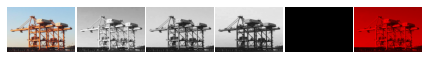

In [4]:
i = plt.imread("anqiao.PNG")
i1 = i[:,:,0]
i2 = i[:,:,1]
i3 = i[:,:,2]
i4 = i[:,:,3]
x = np.zeros((176,267,3))
x[:,:,0]=i1
# x[:,:,1]=i2
# x[:,:,2]=i3

print(i.shape)
print(i1[20][:10])
print(i2[20][:10])
print(i3[20][:10])
print(i4[20][:10])
show_img(i,i1,i2,i3,i4,x)

通过不同的结构元素，能够实现不同的效果，下图显示了几种不同结构元素的膨胀效果。图中结构元素分别为：

左

   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0          
   
   1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1          
   
   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 
   
中

   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0          
   
   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0          
   
   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 
   
右

   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0          
   
   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0          
   
   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 

![图像处理2](./图像处理2.png)

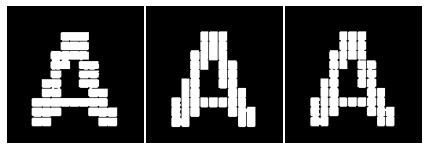

In [9]:
img4 = morphology.binary_dilation(a,[[0,0,0],[1,1,1],[0,0,0]])
img5 = morphology.binary_dilation(a,[[0,1,0],[0,1,0],[0,1,0]])
img6 = morphology.binary_dilation(a,[[0,1,0],[0,1,0],[0,0,0]])

show_img(img4,img5,img6)

binary_erosion()的腐蚀运算正好和膨胀运算相反，它将周围有黑色像素的白色像素设置成黑色。

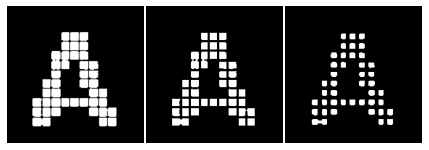

In [10]:
def erosion_demo(a,structure=None):
    b = morphology.binary_erosion(a,structure)
    img = expand_img(a,255)
    return expand_img(np.logical_xor(a,b),100,out=img)

img7 = expand_img(a,255)
img8 = morphology.binary_erosion(a)
img9 = morphology.binary_erosion(a,np.ones((5,5),np.int))
show_img(img7,img8,img9)

### 2.Hit 和Miss

Hit和Miss是二值图像处理中最基本的运算，几乎所有的运算都可以用Hit和Miss的组合推演出来。

原理：对图像的每个像素周围的像素进行模式判断，如果周围像素的黑白模式符合指定的模式，则此像素为白色，否则设置为黑色。由于需要同时对白色和黑色像素进行判断，所以需要指定两个结构元素。调用形式如下：

binary_hit_or_miss(input,structure1=None,structure2=None,···)

其中structure1为指定白色像素的结构元素，structure2为指定黑色像素的结构元素。


如下使用binart_hit_or_miss运算结果：

白色结构像素

   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0          
   
   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0          
   
   1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1 
   
黑色结构像素

   1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0          
   
   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0          
   
   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 

在这两个结构元素中，0表示不关心对应位置的像素，1表示对于位置像素必须为结构元素所表示颜色。通过上面两个结构元素可以找到“下方三个像素为白色，并且左上像素为黑色的白色像素”。

下面右图对应的结构元素为“下方三个像素为白色，左上像素为黑色的黑色像素”，其对应的结构元素如下：

白色结构像素

   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0          
   
   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0          
   
   1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1 
   
黑色结构像素

   1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0          
   
   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0          
   
   0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0 

![图像处理3](./图像处理3.png)

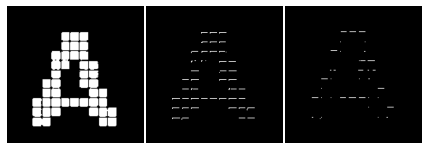

In [11]:
img1 = expand_img(a,255)

img2 = morphology.binary_hit_or_miss(a,[[0,0,0],[0,1,0],[1,1,1]],[[1,0,0],[0,0,0],[0,0,0]])
img3 = morphology.binary_hit_or_miss(a,[[0,0,0],[0,0,0],[1,1,1]],[[1,0,0],[0,1,0],[0,0,0]])

show_img(img1,img2,img3)

### 图像细线化

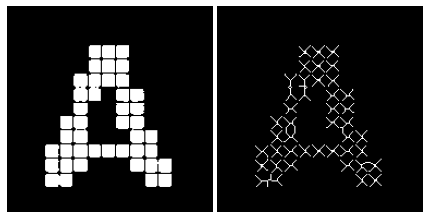

In [12]:
def skeletonize(img):
    h1 = np.array([[0, 0, 0],[0, 1, 0],[1, 1, 1]])
    m1 = np.array([[1, 1, 1],[0, 0, 0],[0, 0, 0]])
    h2 = np.array([[0, 0, 0],[1, 1, 0],[0, 1, 0]])
    m2 = np.array([[0, 1, 1],[0, 0, 1],[0, 0, 0]])
    hit_list = [ ]
    miss_list = [ ]
    for k in range(4):
        hit_list.append(np.rot90(h1,k))
        hit_list.append(np.rot90(h2,k))
        miss_list.append(np.rot90(m1,k))
        miss_list.append(np.rot90(m2,k))
    img = img.copy()
    while True:
        last = img
        for hit, miss in zip(hit_list,miss_list):
            hm = morphology.binary_hit_or_miss(img, hit, miss)
        # 从图像中删除hit_or_miss 所得到的白色点
            img = np.logical_and(img, np.logical_not(hm))
        # 如果处理之后的图像和处理前的图像相同， 则结朿处理
        if np.all(img == last):
            break
    return img

b = skeletonize(a)
show_img(a,b)

In [13]:
h1 = np.array([[0, 0, 0],[0, 1, 0],[1, 1, 1]])
m1 = np.array([[1, 1, 1],[0, 0, 0],[0, 0, 0]])
h2 = np.array([[0, 0, 0],[1, 1, 0],[0, 1, 0]])
m2 = np.array([[0, 1, 1],[0, 0, 1],[0, 0, 0]])
hit_list = [ ]
miss_list = [ ]
for k in range(4):
    hit_list.append(np.rot90(h1,k))
    hit_list.append(np.rot90(h2,k))
    miss_list.append(np.rot90(m1,k))
    miss_list.append(np.rot90(m2,k))
    
print(h1)
print(m1)
print(h2)
print(m2)

[[0 0 0]
 [0 1 0]
 [1 1 1]]
[[1 1 1]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [1 1 0]
 [0 1 0]]
[[0 1 1]
 [0 0 1]
 [0 0 0]]


以图 3-55所示的两个结构元素为基础,构造 4 个形状为(3, 3)的二维数组:h1,m1,h2,m2。其中h1和m1对应图中左边的结构元素， 而h2和m2对应图中右边的结构元素,h1和h2对应白色结构元素,m1和m2对应黑色结构元素。将这搜结构元素进行90°、180°、270°旋转之后一共得到8 个结构元素。

依次使用这些结构元素进行Hit和Miss运算,并从图像屮删除运算所得到的白色像素，其效果就是依次从8 个方向删除图像的边缘上的像素。重复运算直到没有像素可删除为止。

![图像处理4](./图像处理4.png)

## 图像分割

实现步骤：

    1、首先读入三通道图像，提取其中的第0通道并将其转换成二值灰度图像数组。
    2、使用distance_transform_cdt(),得到图像中每个像素距最近黑色像素的距离的数组，该数组与原二值灰度图像数组大小相同。
    3、设定阀值过滤距离数组，将距离值大于10的数组值设为1（白色），小于等于10的数组值设为0（黑色）。
    4、调用measurements模块的label()和center_of_mass()对各个独立的白色区域进行染色，并计算各区域的重心坐标。

### 读取图片，提取灰度图，阀值过滤距离数组

<class 'numpy.ndarray'>
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


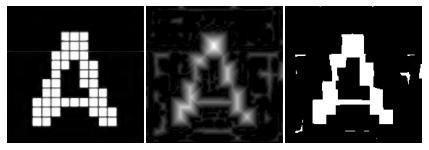

In [49]:
img_gray = plt.imread("图像处理1.png")[:,:,0]
'''返回每个像素到最近的黑色像素的切比雪夫距离（每个像素与最近的黑色像素坐标数值差的最大值）'''
squares_dt = morphology.distance_transform_cdt(img_gray)
'''使用阀值过滤距离大于10的像素'''
squares_core = (squares_dt > 5).astype(np.uint8)
print(type(squares_dt))
print(np.unique(squares_dt))
show_img(img_gray,squares_dt,squares_core)

### 阀值过滤

In [40]:
a = np.array([[1, 2, 3],[4, 5, 6],[7, 8, 9]])
b = (a > 5).astype(np.uint8)
print(b)

[[0 0 0]
 [0 0 1]
 [1 1 1]]


### 区域染色，计算

labels()可以对二值图像中每个独立的白色区域使用唯一的整数进行填充，这相当于给每块区域染色。labels()返冋的结果数组可以用于计算各个区域的一 些统计信息。返回第一个值为一个像素数组，第二个值为区域个数。

center_of_mass()可以计算每块区域的重心。第一个参数为各个元素的权值（可以认为是每个像素的质量密度），第二个参数为labels()输出的染色数组，第三个参数为需要计算重心的区域的标签列表。

(189, 189)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
13


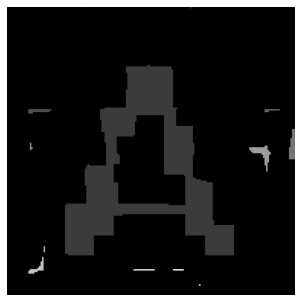

In [85]:
from scipy.ndimage.measurements import label,center_of_mass

labels,count = label(squares_core)

print(labels.shape)
print(np.unique(labels))
print(count)
show_img(labels)

### 随机染色

如果直接使imshow()显示labels()输出的染色数组，将会得到一个区域颜色逐渐变化的图像，这样的图像不利于肉眼识别各个区域。使用下面random_palette()为每个整数分配一个随机颜色。

<class 'numpy.ndarray'>
(189, 189, 3)


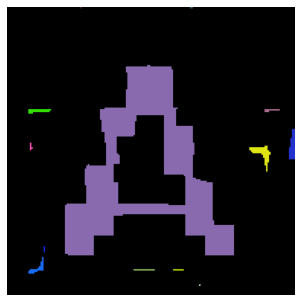

In [80]:
def random_palette(labels,count,seed = 1):
    np.random.seed(seed)
    palette = np.random.rand(count+1,3)
    palette[0,:] = 0
    return palette[labels]

cores = random_palette(labels,count)
print(type(core))
print(core.shape)
show_img(cores)

### 重心坐标提取

使用center_of_mass()函数可以获得每个区域重心位置坐标索引。下面语句将每个区域的重心重新绘制在等大的图像上。

<class 'numpy.ndarray'>
(13, 2)


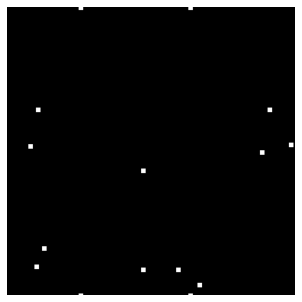

In [81]:
h,w = labels.shape
center = np.array(center_of_mass(labels,labels,index = range(1,count+1)),np.int)
print(type(center))
print(center.shape)
# print(center)
a = np.zeros((189,189),np.int)
for m in range(center.shape[0]):
    i = center[m][0]
    j = center[m][1]
    a[i,j]=1
    a[i,j+1]=1
    a[i,j-1]=1
    a[i-1,j+1]=1
    a[i-1,j-1]=1
    a[i+1,j+1]=1
    a[i+1,j-1]=1
    a[i-1,j]=1
    a[i+1,j]=1
show_img(a)

### 区域恢复+染色

步骤如下：

    1、使用morphology.distance_transform_cdt(),将腐蚀之后的图像（squares_core）反转（1-squares_core）后作为参数传入，其返回值index是一个形状为（2，高，宽）的数组，index[0]是距离最近的白色像素的第0轴（纵）坐标，index[1]是第1轴（横）坐标；
    2、获取labels中对应index位置的坐标，得到near_labels；
    3、创建一个布尔数组mask，其中每个Ture值对应squares中为白色，squares_core中为黑色的像素。将labels复制为labels2，将mask中Ture对应的near_labels中的颜色复制到labels2中。

(2, 189, 189)
(189, 189)


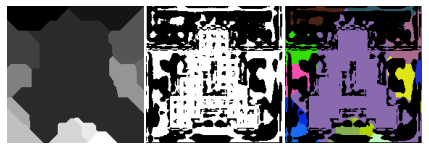

In [90]:
index = morphology.distance_transform_cdt(1-squares_core, #将squares_core反转等于求原图像每个像素与附近最近的白色像素之间的距离
                                          return_distances=False, # return_distances设为false，将不会返回每个像素与最近白色像素之间距离
                                          return_indices=True) #return_indices设为True，将返回每个像素距离最近白色像素的坐标
near_labels = labels[index[0],index[1]] #获取labels中对应位置的坐标，得到near_labels

mask = (img_gray - squares_core).astype(bool)#img_gray中像素和spuares_core中像素相同时为false，否则为Ture
labels2 = labels.copy()
labels2[mask] = near_labels[mask] #将mask中Ture对应的near_labels中的颜色复制到labels2中
separated = random_palette(labels2, count) #为labels2重新染色

print(index.shape)
print(mask.shape)
show_img(near_labels,mask,separated)